# Example Usage

Results are still preliminary. This gives a toy example for how to use the code in this repository for model training, inference, and result visualization. Performance is not yet optimized and there are still more validation tests to finish.

In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np
import torch
import torch.nn.functional as F
from max_deeplab.model import MaXDeepLabS
from max_deeplab.losses import MaXDeepLabLoss
from datasets.coco_panoptic import build
from torch.optim import Adam
from util.misc import collate_fn
from torch.utils.data import DataLoader
from util.visualize import display_instances, roll_image

from einops import rearrange
from matplotlib import pyplot as plt

In [22]:
config = {}
HW = 224
N = 30 #if the loaded image has more than 30 masks, this number must be increased
bsz = 60 #small batch for a toy example; too small for actual model training

config['image_size'] = (HW, HW)
config['coco_path'] = 'coco_panoptic/' #directory with image and annotation data
data = build('train', config)

#dictionary of class names from Coco Panoptic
category_dict = {dct['id']: dct['name'] for dct in data.coco['categories']}
category_dict[201] = 'no_class'

#create a dataloader that collates batch with padding
#see utils.misc.collate_fn
padding_dict = {'image': 0, 'masks': 0, 'semantic_mask': 0, 'labels': 0, 'image_id': 0} #padding values
sizes_dict = {'image': None, 'masks': N, 'semantic_mask': None, 'labels': N, 'image_id': None} #padded sizes
collate_lambda = lambda b: collate_fn(b, padding_dict, sizes_dict)

loader = DataLoader(data, batch_size=bsz, shuffle=True, collate_fn=collate_lambda, drop_last=True)

#we will just try to overfit a single batch of images
batch = iter(loader).next() # 加载batch，设置循环规则

In [ ]:
import cv2
pred_path = ''
pred_P = {}
pred_img = cv2.imread(pred_path)
pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)
pred_P['image'] = pred_img
loader =

In [27]:
device = torch.device('cuda:0')

# 分别放置当前批里的东西
P = batch['image'].to(device)
masks = batch['masks'].to(device)
labels = batch['labels'].to(device)
semantic = batch['semantic_mask'].to(device)

# 造gt元组
target_tuple = (masks, labels, semantic)

In [5]:
model = MaXDeepLabS(im_size=HW, n_classes=202, n_masks=N).cuda() # 每做完一步输出遮罩、类别、语义遮罩？
criterion = MaXDeepLabLoss().cuda() # loss
optimizer = Adam(model.parameters(), lr=5e-4) #RAdam later, just Adam for testing

In [6]:
for i in range(1500):
    optimizer.zero_grad()

    out = model(P)
    loss, loss_items = criterion(out, target_tuple)
    loss.backward()
    optimizer.step()

    if (i + 1) % 50 == 0:
        loss_string = ', '.join([f'{k}: {v}' for k,v in loss_items.items()])
        print(f'epoch {i + 1}: ', loss.item())
        print(loss_string)

epoch 50:  2.2880284786224365
pq: 0.2963877022266388, semantic: 0.8255376219749451, maskid: 1.9055428504943848, instdisc: 0.001664874143898487
epoch 100:  1.6331095695495605
pq: 0.2579723596572876, semantic: 0.4084395468235016, maskid: 1.4913134574890137, instdisc: 0.0033589645754545927
epoch 150:  1.6424143314361572
pq: 0.33194443583488464, semantic: 0.2371937781572342, maskid: 1.3587747812271118, instdisc: 0.0017547339666634798
epoch 200:  1.4983906745910645
pq: 0.31754446029663086, semantic: 0.15524694323539734, maskid: 1.2985827922821045, instdisc: 0.0009354796493425965
epoch 250:  1.4354726076126099
pq: 0.30731114745140076, semantic: 0.12555253505706787, maskid: 1.2910737991333008, instdisc: 0.0006644214736297727
epoch 300:  1.3942092657089233
pq: 0.300971657037735, semantic: 0.10865981131792068, maskid: 1.273319959640503, instdisc: 0.0006383976433426142
epoch 350:  1.3398102521896362
pq: 0.29023197293281555, semantic: 0.09734472632408142, maskid: 1.237973928451538, instdisc: 0.00

In [ ]:
    gt_instances = []
    gt_classes = []
    gt_class_names = []

    pred_instances = []
    pred_classes = []
    pred_class_names = []

In [ ]:
for i in range(30):
    config = {}
    HW = 224
    N = 30 #if the loaded image has more than 30 masks, this number must be increased
    bsz = 2 #small batch for a toy example; too small for actual model training

    config['image_size'] = (HW, HW)
    config['coco_path'] = 'coco_panoptic/' #directory with image and annotation data
    data = build('train', config)

    #dictionary of class names from Coco Panoptic
    category_dict = {dct['id']: dct['name'] for dct in data.coco['categories']}
    category_dict[201] = 'no_class'

    #create a dataloader that collates batch with padding
    #see utils.misc.collate_fn
    padding_dict = {'image': 0, 'masks': 0, 'semantic_mask': 0, 'labels': 0, 'image_id': 0} #padding values
    sizes_dict = {'image': None, 'masks': N, 'semantic_mask': None, 'labels': N, 'image_id': None} #padded sizes
    collate_lambda = lambda b: collate_fn(b, padding_dict, sizes_dict)

    loader = DataLoader(data, batch_size=bsz, shuffle=True, collate_fn=collate_lambda, drop_last=True)

    #we will just try to overfit a single batch of images
    batch = iter(loader).next() # 加载batch，设置循环规则
    device = torch.device('cuda:0')

    # 分别放置当前批里的东西
    P = batch['image'].to(device)
    masks = batch['masks'].to(device)
    labels = batch['labels'].to(device)
    semantic = batch['semantic_mask'].to(device)

    # 造gt元组
    target_tuple = (masks, labels, semantic)
    with torch.no_grad():

        out = model(P)

        instance_probs = F.softmax(out[0], dim=1)
        instances = instance_probs.argmax(dim=1)
        instances = F.one_hot(instances, num_classes=N).permute(0, 3, 1, 2)

        #filter out pixels by mask id confidence
        #instances[instance_probs < 0.4] = 0

        class_confidence, classes = F.softmax(out[1], dim=-1).max(-1)

        semantic = F.softmax(out[2], dim=1).argmax(dim=1)

        #throughout padding instances in gt
        keep_gt_instances = torch.where(batch['labels'].tensors > 0)

        #filter out low confidence instances from predictions
        keep_pred_instances = torch.where(torch.logical_and(classes > 0, class_confidence > 0.7))


In [26]:
#basic inference
with torch.no_grad():

    out = model(P)

    instance_probs = F.softmax(out[0], dim=1)
    instances = instance_probs.argmax(dim=1)
    instances = F.one_hot(instances, num_classes=N).permute(0, 3, 1, 2)
    
    #filter out pixels by mask id confidence
    #instances[instance_probs < 0.4] = 0
    
    class_confidence, classes = F.softmax(out[1], dim=-1).max(-1)

    semantic = F.softmax(out[2], dim=1).argmax(dim=1)

    #throughout padding instances in gt
    keep_gt_instances = torch.where(batch['labels'].tensors > 0)

    #filter out low confidence instances from predictions
    keep_pred_instances = torch.where(torch.logical_and(classes > 0, class_confidence > 0.7))

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [23]:
gt_instances = []
gt_classes = []
gt_class_names = []

pred_instances = []
pred_classes = []
pred_class_names = []

for index in range(bsz):
    keep_gt = keep_gt_instances[1][keep_gt_instances[0] == index]
    keep_pred = keep_pred_instances[1][keep_pred_instances[0] == index]
    
    gt_instances.append(batch['masks'].tensors.detach()[index, keep_gt].cpu().numpy())
    gt_classes.append(batch['labels'].tensors.detach()[index, keep_gt].cpu().numpy())
    gt_class_names.append([category_dict[l] for l in gt_classes[-1]])

    pred_instances.append(instances.detach()[index, keep_pred].cpu().numpy())
    pred_classes.append(classes.detach()[index, keep_pred].cpu().numpy())
    pred_class_names.append([category_dict[l] for l in pred_classes[-1]])

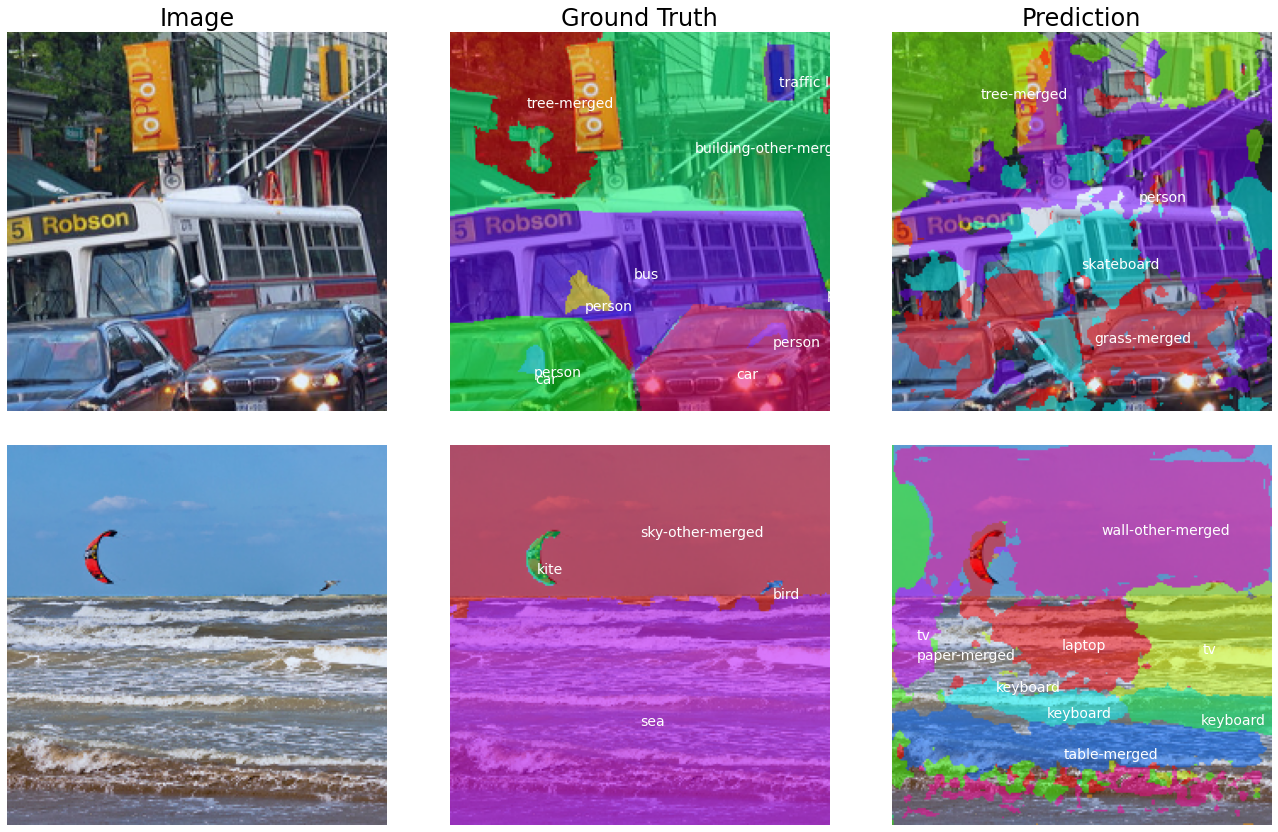

In [24]:
f, ax = plt.subplots(bsz, 3, figsize=(18, 6*bsz), squeeze=False)

for index in range(bsz):
    display_image = roll_image(batch['image'].tensors.detach().cpu().numpy()[index])
    ax[index, 0].imshow(display_image)
    ax[index, 0].axis('off')
    display_instances(display_image, gt_instances[index], gt_class_names[index], ax=ax[index, 1])
    display_instances(display_image, pred_instances[index], pred_class_names[index], ax=ax[index, 2])

ax[0, 0].set_title('Image', fontsize=24)
ax[0, 1].set_title('Ground Truth', fontsize=24)
ax[0, 2].set_title('Prediction', fontsize=24)
plt.tight_layout()